In [1]:
import os
import numpy as np
import pandas as pd
import importlib
from tqdm import tqdm
import skimage.io

#supporting functions:
import Colony_Analysis as ca
import Plate_Shuffling as ps
from matplotlib import pyplot as plt


In [2]:

import math
from warnings import warn
from scipy.spatial import distance
from scipy.signal import find_peaks
from scipy.stats import trim_mean
import math

from skimage.color import rgb2gray
from skimage.filters import threshold_otsu, gaussian, threshold_local
from skimage.morphology import remove_small_objects
from skimage.segmentation import clear_border
from skimage.util import invert
from skimage.measure import regionprops, label
from skimage.color import label2rgb
from skimage.draw import rectangle_perimeter
from skimage.transform import rescale, resize, downscale_local_mean
import os
import seaborn as sns
from scipy import stats



import pickle
from scipy import stats

import torch
import torch.nn as nn
import torch.nn.functional as F

import plotly.graph_objects as go
import plotly.express as px



In [ ]:
## this Notebook extract colony metrics from images of CRI-SPA arrays
##Many Pyphe functions (https://github.com/Bahler-Lab/pyphe) were re-used/tweaked in the analysis

#### Generate an empty DF storing all Plate, Row, Column positions within the screen



In [3]:
#generate the random order with which plates were shuffled
order = ps.Shuffle_384to1536(1)
### re-creates the map of randomized genes of the YKO 
shuffled_plate_map = ps.plate_map_maker(order, MapFilePath='Plate_Map.txt')

#create the plate,row,col coordinate system to store the data, we used 1536 (32rows, 48 columns) plates
n_row=32
n_col=48
n_plate=13
row = np.arange(0, n_row)
col = np.arange(0, n_col)
col,row = np.meshgrid(col,row)
plate= np.arange(0,n_plate)
row_col = np.vstack((row.flatten(),col.flatten())).T
plate=np.repeat(plate,n_row * n_col).reshape(-1,1)
row_col =np.tile(row_col.T,n_plate).T
coordinate= np.hstack([plate, row_col])
#create the gene name column (!! need to use the right plate map)
gene_col=[] #stores the gene ID
for p in range(n_plate):
    gene_col.append(shuffled_plate_map[p+1].flatten())
gene_col = np.hstack(gene_col).reshape(-1,1)

#create the data frame storing a read-out for each individual position
Data=pd.DataFrame(data=np.hstack((gene_col,coordinate)), columns=['gene','plate', 'row', 'column'])
Data['plate']=Data['plate'].astype('int64')
Data['row']=Data['row'].astype('int64')
Data['column']=Data['column'].astype('int64')


#### Extract Metrics from Raw images and fills our Data Frame:

In [4]:
#we first retrieve the plates name (files always finish with '-Ctrl.png')
image_path = 'Screen_Sample/'# YUGN24T-Run-1-Plate-001-Ctrl
plate_path_dict={}

#this follows image_path to read the plate name 
for filename in os.listdir(image_path):
    if '-Ctrl.png' in filename:
        i = filename.index('-Ctrl.png') -3
        plate_num = int(filename[i:i+3])
        plate_path_dict[plate_num] = image_path+ '/' + filename

In [5]:
#extract colony size and yellowness with HSV map

plot=0 #option to plot figures when running extraction:


# set some Pyphe paramters
#s,t,d,i >>size_threshold parameter/ image back_ground threshold parameter/ d?/invert image
#background thresh the lower the more the background is sensed as colony
s,t,d, negate = [0.3,1,2, 0]
grid_size='32-48' #screen is in 1536 format
QC=dict() #dict will store Quality control images



#initialize the object storing our data
Area= np.zeros((32,48,13))
Mean_intensity = np.zeros((32,48,13))

#loop extracting the data: Lets GO!
for p, plate in plate_path_dict.items():
    print(plate +'... processed')
    im=skimage.io.imread(plate)
    #we crop the pictures
    im=im[460:1432,530:1990]
    plate_data, QC[p] = ca.quantify_single_image_HSV(im,grid_size, True,t,d,s, negate,ca.rgb2gray, ca.HSV_filter  )
    # we reformat the data to match our plate format
    for i in range(len(plate_data)):
        r = int(plate_data.iloc[i,5])
        c = int(plate_data.iloc[i,6])
        Mean_intensity[r-1,c-1,p-1]  = plate_data.iloc[i,3]
        Area[r-1,c-1,p-1] = plate_data.iloc[i,1]

    if plot:
        plt.figure(figsize=(15,15))
        plt.subplot(1,3,1)
        plt.imshow(im[:,0:400])
        plt.subplot(1,3,2)
        plt.imshow(QC[p][:,0:400,:])
        plt.subplot(1,3,3)
        plt.imshow(Mean_intensity[:,0:13,p-1] )
        plt.show()

## we transfer the data to our final data frame
Data['area'] = Area.transpose(2,0,1).flatten()
Data['mean_intensity'] = Mean_intensity.transpose(2,0,1).flatten()

## Save unprocessed data:

#Data.to_csv('your_path/Raw_Data.csv', sep=',')


Screen_Sample//YUGN24_T-001-Ctrl.png... processed
Screen_Sample//YUGN24_T-002-Ctrl.png... processed


### We now process data in several steps:

In [ ]:
## 1) correct edge effects
## 2) Turns 0 to nan and standardise the data
## 3) Filter outlier colonies (Grubbs' test) 


In [6]:
#correct for edge effects, only the column in metrics are corrected
metrics=[c for c in Data.columns if 'intensity' in c or 'area' in c]
#correct for edge effect:
Data_corrected = ca.correct_edges(Data,  metrics, default_cols=['gene','plate','row','column'],n_edges =5)


metrics=[c for c in Data.columns if 'intensity' in c or 'area' in c]
#correct for edge effect:
Data_corrected = ca.correct_edges(Data,  metrics, default_cols=['gene','plate','row','column'], n_edges = 12)




/Users/paucac/Documents/PhD/CAB/CRISPA/CRISPA_plates/ColonyAnalysisEnv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/paucac/Documents/PhD/CAB/CRISPA/CRISPA_plates/ColonyAnalysisEnv/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/paucac/Documents/PhD/CAB/CRISPA/CRISPA_plates/ColonyAnalysisEnv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/paucac/Documents/PhD/CAB/CRISPA/CRISPA_plates/ColonyAnalysisEnv/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/paucac/Documents/PhD/CAB/CRISPA/CRISPA_plates/ColonyAnalysisEnv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=

/Users/paucac/Documents/PhD/CAB/CRISPA/CRISPA_plates/ColonyAnalysisEnv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/paucac/Documents/PhD/CAB/CRISPA/CRISPA_plates/ColonyAnalysisEnv/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/paucac/Documents/PhD/CAB/CRISPA/CRISPA_plates/ColonyAnalysisEnv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/paucac/Documents/PhD/CAB/CRISPA/CRISPA_plates/ColonyAnalysisEnv/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/paucac/Documents/PhD/CAB/CRISPA/CRISPA_plates/ColonyAnalysisEnv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=

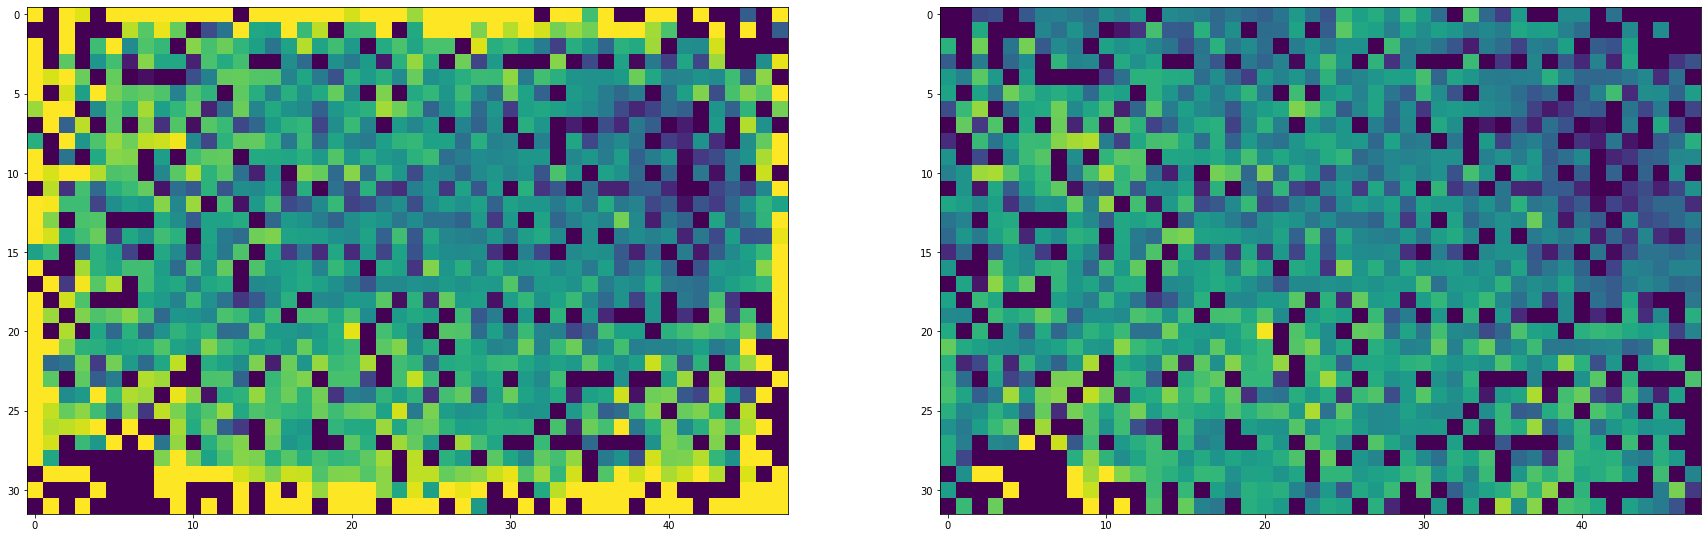

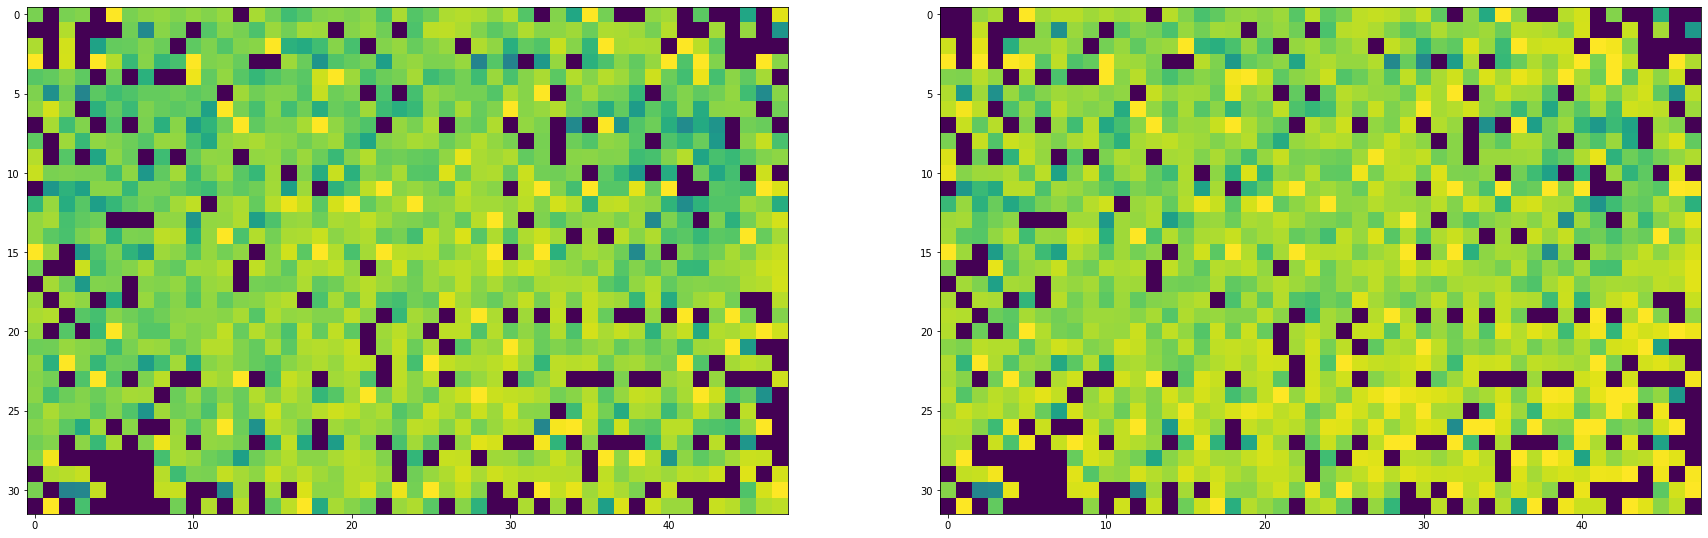

In [7]:
#check:
p=0
metric='area'
DF = Data_corrected.copy()
before= DF.loc[DF['plate']== p, metric]
after= DF.loc[DF['plate']== p,'corrected_' + metric]
plt.figure(figsize=[30,30])
plt.subplot(1,2,1)

plt.imshow(before.values.reshape((32,48)), vmin=before.mean()-before.std(), vmax=before.mean()+before.std())
plt.subplot(1,2,2)
plt.imshow(after.values.reshape((32,48)), vmin=before.mean()-before.std(), vmax=before.mean()+before.std())
plt.show()


metric='mean_intensity'
before= DF.loc[DF['plate']== p, metric]
after= DF.loc[DF['plate']== p,'corrected_' + metric]
plt.figure(figsize=[30,30])
plt.subplot(1,2,1)
plt.imshow(before.values.reshape((32,48)), vmin=0, vmax= before.mean()+before.std())
plt.subplot(1,2,2)
plt.imshow(after.values.reshape((32,48)), vmin=0,vmax=before.mean()+before.std())
plt.show()


In [9]:
# We are going to standardise the data
#Pyphe returns a 0 read-out for empty position. we need to convert this 0 to nans
#turn 0 into NaNs
metrics = [m for m in Data_corrected.columns if 'area' in m or 'intensity'  in m   ]
Data_corrected[metrics] = Data_corrected[metrics].replace(0, np.nan)


In [9]:
## this cell removes (i.e. set their readouts to NaN) outliers and genes with less than 3 replicates

#1) Removes genes with less than 3 replicates
#2) Compute Z score for individual replicates
#3) Remove replicate outliers if Z > threshold
#4) Removes genes with less than 3 replicates after outliers removal

#Filter data for individual and combined data
metrics=[c for c in Data_corrected.columns if 'area' in c or 'intensity' in c]
#1)
Data_corrected = ca.Filter_3(Data_corrected, metrics)
#2)
Data_corrected = ca.Compute_Zscore(Data_corrected,metrics)
#3)
Data_corrected = ca.Filter_Z(Data_corrected, metrics)
#4)
Data_corrected = ca.Filter_3(Data_corrected,  metrics)

100%|██████████| 4/4 [00:06<00:00,  1.55s/it]


In [10]:
# here we compute the mean, std, and count for each gene
#the replicate number for each metric
metrics=[c for c in Data_corrected.columns if 'area' in c or 'intensity' in c]
Plate_Data = ca.group_by_gene(Data_corrected, metrics)

In [11]:
#save data
Plate_Data.to_csv('Gene_Data.csv', sep=',')
Data_corrected.to_csv('Individual_Colony_Data.csv', sep=',')



### Visualize Screen Result

In [10]:
##Load data
Plate_Data = pd.read_csv('Gene_Data_i.csv')

top middle difference 3.397807564086679e-08
middle down difference 3.397807564086679e-08


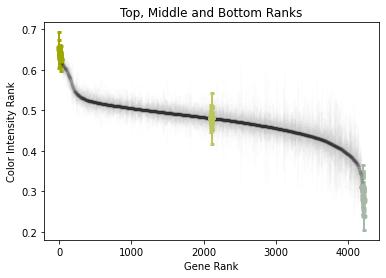

In [11]:
#Produce Screen Rank

from scipy.stats import mannwhitneyu
metric = 'corrected_mean_intensity'


i_nan = Plate_Data[metric+'_mean'].isna() ==0

i_sort =  Plate_Data[i_nan][metric+'_mean'].argsort()[::-1]
i_middle_group =  np.arange(len( Plate_Data[i_nan])/2-10,len( Plate_Data[i_nan])/2+10)
i_top_group =  np.arange(0,20)
i_bottom_group =  np.arange(-20,0)

i_all= np.arange(i_nan.sum())
All= Plate_Data[i_nan].iloc[i_sort][metric+'_mean']
All_err= Plate_Data[i_nan].iloc[i_sort][metric+'_std']

Top = Plate_Data[i_nan].iloc[i_sort].iloc[i_top_group][metric+'_mean']
Top_err = Plate_Data[i_nan].iloc[i_sort].iloc[i_top_group][metric+'_std']
Top_genes = Plate_Data[i_nan].iloc[i_sort].iloc[i_top_group]['gene'].values
Middle =  Plate_Data[i_nan].iloc[i_sort].iloc[i_middle_group][metric+'_mean']
Middle_err = Plate_Data[i_nan].iloc[i_sort].iloc[i_middle_group][metric+'_std']
Middle_genes =  Plate_Data[i_nan].iloc[i_sort].iloc[i_middle_group]['gene'].values
                                                                    
Bottom = Plate_Data[i_nan].iloc[i_sort].iloc[i_bottom_group][metric+'_mean']
Bottom_err = Plate_Data[i_nan].iloc[i_sort].iloc[i_bottom_group][metric+'_std']
Bottom_genes = Plate_Data[i_nan].iloc[i_sort].iloc[i_bottom_group]['gene'].values

Bottom_color=[168/255,184/255,167/255]
Middle_color=[187/255,199/255,90/255]
Top_color=[158/255,167/255,0]

i = np.arange(0,len(i_all), 1)
#plt.errorbar(i_all[i], All.iloc[i], All_err.iloc[i], linestyle='', marker = '.', color='k', alpha=0.1)
plt.errorbar(i_all[i], All.iloc[i], All_err.iloc[i], linestyle='', marker = '.', color='k', alpha=0.01)

plt.errorbar(i_middle_group, Middle, Middle_err, c=Middle_color , marker = '.',  capsize=2, elinewidth=2, markeredgewidth=3)

plt.errorbar(i_top_group,Top, Top_err, c=Top_color, marker = '.',  capsize=2, elinewidth=2, markeredgewidth=3 )

plt.errorbar(i_bottom_group+len(i_all),Bottom, Bottom_err, c=Bottom_color, marker = '.',  capsize=2, elinewidth=2, markeredgewidth=3 )
plt.title('Top, Middle and Bottom Ranks')
plt.xlabel('Gene Rank')
plt.ylabel('Color Intensity Rank')
U1, p = mannwhitneyu( Top, Middle)
print('top middle difference',p)
U1, p = mannwhitneyu(Middle, Bottom)
print('middle down difference',p)


### Display Colony Pictures From Plates:

In [14]:
%%time
#to avoid reopenning images and find their grids for each colony we store the images and the grids in a dict:

pic_dict={} #dictionary storing images and colony positions (grid)
    
for p, plate in plate_path_dict.items(): 
    im=skimage.io.imread(plate)
    im=im[460:1432,530:1990]
    im4grid =  ca.prepare_yellowness_image(im, ca.YPD_yellow)
    grid, griddist = ca.make_grid_auto(im4grid, '32-48')
    pic_dict['p'+ str(p)]=[im,grid]
            
            

CPU times: user 27.8 s, sys: 857 ms, total: 28.6 s
Wall time: 29.6 s


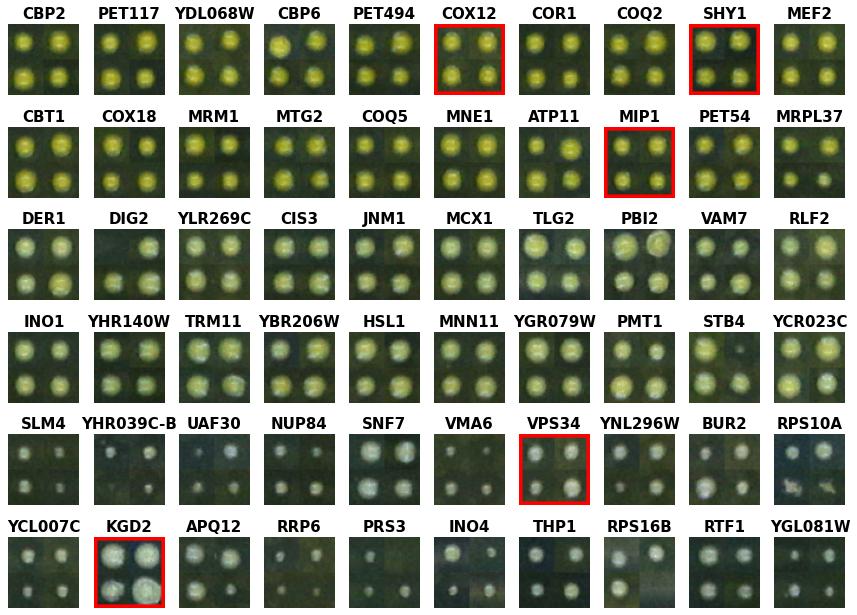

In [84]:
## this loop might look complex, 
## it is because we need to retrieve the positions of the 4 randomized replicates for the genes we want to plot:
fig, axs= plt.subplots(6,10, figsize=(15,11))
axs= axs.flatten()
frame_opt = 30 #number of pixels framing the center of the colony
for i_plot, gene in enumerate(np.hstack([Top_genes,Middle_genes,Bottom_genes])):

    #find coordinate of colonies in shuffled plate
    plates,rows,cols = ca.gene_loc_finder(gene , shuffled_plate_map)

    # go and find the picture of the colony on the plate
    replicates=[]
    for i, p in enumerate(plates):
        r=rows[i]
        c= cols[i]
        pic = pic_dict['p'+str(p+1)][0] #10.2.22
        grid = pic_dict['p'+str(p+1)][1]
        colony=ca.colony_picker(pic, r, c, grid,frame_opt )
    
        replicates.append(colony)

    #stack colony pictures:
    replicates = np.vstack((np.hstack((replicates[0],replicates[1])),np.hstack((replicates[2],replicates[3]))))
    #underline edge colonies with red
    #frame the genes selected for comfirmation in red
    if gene in ['VPS34','KGD2', 'CAX4', 'CUR1', 'NAM7', 'YKU70','COX12', 'SHY1', 'MIP1']:
        replicates[-3:,:,:]=[255,0,0]
        replicates[0:3,:,:]=[255,0,0]
        replicates[:,0:3,:]=[255,0,0]
        replicates[:,-3:,:]=[255,0,0]

    axs[i_plot].axis('off')
    axs[i_plot].imshow(replicates,vmin=0, vmax=255)
    axs[i_plot].set_title(gene, size=15,fontweight="bold")
plt.show()